In [ ]:
# 1. Install the required packages
# On Windows, you just need to execute this cell for once.
try:
    import google.colab
    # IN_COLAB = True
except ImportError:
    # IN_COLAB = False
    %pip install -q git+https://github.com/huggingface/transformers
    %pip install -q git+https://github.com/huggingface/accelerate

%pip install -q git+https://github.com/huggingface/diffusers
%pip install -q gradio ftfy tensorboard
%pip install -q bitsandbytes
#%pip install -U git+https://github.com/TimDettmers/bitsandbytes.git
%pip install -q xformers --index-url https://download.pytorch.org/whl/cu124
#%pip install -U git+https://github.com/facebookresearch/xformers.git@main
print("Package installation finished.")

In [1]:
# 2. Create folders and download training scripts
import os, shutil

#global variables
dataset_dir = "./dataset"
output_dir = "./output"
logging_dir = "./logs"

token_name = ""
pipeline = None

available_models = {
    "SD v1.5": "stable-diffusion-v1-5/stable-diffusion-v1-5",
    # "SDXL": "stabilityai/stable-diffusion-xl-base-1.0"
}

def reset_data():
    # Create the directories if they don't exist
    # shutil.rmtree(dataset_dir, ignore_errors=True)
    os.makedirs(dataset_dir, exist_ok=True)
    # Delete the 'output' folder and its contents
    shutil.rmtree(output_dir, ignore_errors=True)
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir,"images"), exist_ok=True)
    # Delete the 'log' folder and its contents
    shutil.rmtree(logging_dir, ignore_errors=True)
    os.makedirs(logging_dir, exist_ok=True)
    # Delete the 'dataset' folder and its contents
    # shutil.rmtree(dataset_dir, ignore_errors=True)
    # os.makedirs(dataset_dir, exist_ok=True)

    # fetch textual inversion code if it doesn't exist
    if not os.path.exists("textual_inversion.py"):
        !wget https://raw.githubusercontent.com/jomo0825/MrFuGenerativeAI/main/TextualInversion/textual_inversion.py
    else:
        print("textual_inversion.py already exists, skipping download.")

    ipynb_checkpoints = os.path.join( dataset_dir, ".ipynb_checkpoints")
    shutil.rmtree(".gradio", ignore_errors=True)
    shutil.rmtree(".config", ignore_errors=True)
    shutil.rmtree(ipynb_checkpoints, ignore_errors=True)

reset_data()

textual_inversion.py already exists, skipping download.


In [ ]:
# 3. Open WebUI
import gradio as gr
from textual_inversion import main as train_textual_inversion
from textual_inversion import parse_args
# from textual_inversion_sdxl import main as train_textaul_inversion_sdxl
# from textual_inversion_sdxl import parse_args as parse_args_sdxl
import threading, os, logging, time
from os import path
from PIL import Image

def parse_lr_schedule(lr_schedule_str):
    schedule = []
    segments = lr_schedule_str.split(',')
    for segment in segments:
        if ':' in segment:
            lr, steps = segment.split(':')
            schedule.append((float(lr), int(steps)))
        else:
            schedule.append((float(segment), None))  # Final constant learning rate
    return schedule

def get_learning_rate_at_step(lr_schedule, step):
    current_step = 0
    for lr, segment_steps in lr_schedule:
        if segment_steps is None or step < current_step + segment_steps:
            return lr
        current_step += segment_steps
    return lr_schedule[-1][0]  # Return the last LR if beyond defined steps

# Callback to update the preview image in the UI
# def preview_callback(image, step):
#     global current_preview, current_status, max_train_steps, current_step
#     current_step = step
#     current_preview = image
#     # current_status = f"Preview updated at step {step}"
#     # current_preview.show()
#     print(f"{step}/{max_train_steps}")
def preview_callback(image, step):
    global current_preview, current_status, max_train_steps, current_step
    current_step = step
    if image is not None:
        current_preview = image
        image.save(os.path.join(output_dir, "images", f"image_{step}.png"))
    
def stop_training():
  global stop_flag
  stop_flag.set()
  return gr.update(value="Training will be stopped...Waiting for the final preview...")

def run_training(model_name, prompt, placeholder_token, initializer_token, concept_type, num_training_steps,
                 learning_rate, batch_size, acc_steps, preview_save_steps, preview_seed):
    global current_preview, current_status, token_name, pipeline
    global max_train_steps, current_step, finish_event, stop_flag
    current_preview = None  # Reset the preview
    token_name = placeholder_token
    current_status = "Training started..."  # Initial status
    pipeline = None

    # Construct the command with all arguments
    command = [
        # "python", "textual_inversion.py",
        "--pretrained_model_name_or_path", available_models[model_name],
        "--train_data_dir", dataset_dir,
        "--placeholder_token", placeholder_token,
        "--initializer_token", initializer_token,
        "--resolution", str(512),
        "--train_batch_size", str(batch_size),
        "--gradient_accumulation_steps", str(acc_steps),
        "--learning_rate", str(learning_rate),
        "--lr_scheduler", str("cosine"),
        "--max_train_steps", str(num_training_steps),
        "--save_steps", str(preview_save_steps),
        "--validation_steps", str(preview_save_steps),
        "--output_dir", output_dir,
        "--logging_dir", logging_dir,
        "--validation_prompt", prompt,
        "--learnable_property", concept_type,
        "--seed", str(preview_seed),
        "--mixed_precision", "fp16",
        # "--enable_xformers_memory_efficient_attention",
    ]

    # Print the command for debugging
    # print("Command:", " ".join(command))
    # Disable logging
    logging.getLogger("accelerate").disabled = True

    args = parse_args(command)

    # yield gr.update(value=None), gr.update(value=" ".join(command))

    max_train_steps = args.max_train_steps

    def worker(finish_event, stop_flag):
      try:
        train_textual_inversion(args, {"_callback": preview_callback, "stop_flag": stop_flag})
      except Exception as e:
        print(f"Training error: {e}")
      finally:
        finish_event.set()

    finish_event = threading.Event()
    stop_flag = threading.Event()
    finish_event.clear()
    stop_flag.clear()

    train_thread = threading.Thread(target=worker, args=(finish_event, stop_flag))
    train_thread.start()
    yield gr.update(value=None), gr.update(value=f"Training started.")

    # except Exception as e:
    #   print(f"Error: {e}")

    current_step = None
    while not finish_event.is_set():
        if current_step is not None:
            yield gr.update(value=current_preview), gr.update(value=f"Trainng on {current_step} step.")
            current_step = None
        time.sleep(1)

    train_thread.join()

    # Print the output and errors (for debugging)
    # print("Output:", stdout.decode())
    # print("Errors:", stderr.decode())

    # Update status when training completes
    current_status = "Training completed!"

    yield gr.update(value=current_preview), gr.update(value=current_status)


# Define a function to move the selected file
def copy_file(target_directory, file_path):
  if file_path is not None:
      filename = os.path.basename(file_path)
      destination_path = os.path.join(target_directory, filename)
      # test if the destination_path alread exist
      if not os.path.exists(destination_path):
        shutil.copy(file_path, destination_path)
        print(f"Copy {filename} to {target_directory}")
      else:
        print(f"{filename} already exists.")
  else:
      print("No file selected.")

def process_files(files):
    file_info = []

    for file in files:
        fileBasename = os.path.basename(file)
        destination_path = os.path.join(dataset_dir, fileBasename)
        if not os.path.exists(destination_path):
            file_info.append(f"File: {file.name}")
            copy_file(dataset_dir, file.name )
    return f"{len(file_info)} files uploaded."

def delete_dataset():
  shutil.rmtree(dataset_dir, ignore_errors=True)
  os.makedirs(dataset_dir, exist_ok=True)
  return "Dataset deleted."

def ui():
    with gr.Blocks() as demo:
        gr.Markdown("# Stable Diffusion Textual Inversion UI")
        gr.Markdown("Generate images using a preloaded textual inversion model.")

        with gr.Row():
            model_name = gr.Dropdown(
                label="Model Name",
                choices=available_models.keys(),
                value= list(available_models.keys())[0] if available_models.keys() else "Select a Model",
                interactive=True
            )

        with gr.Row():
            file_input = gr.File(file_count="multiple", label="Upload Files")
        with gr.Row():
            submit_btn = gr.Button("Upload Files")
            delete_data_btn = gr.Button("Delete Dataset")
        with gr.Row():
            output = gr.Textbox(label="Results")
        submit_btn.click(fn=process_files, inputs=file_input, outputs=output)
        delete_data_btn.click(fn=delete_dataset, outputs=output)

        with gr.Row():
            with gr.Column(scale=1, min_width=300):
                placeholder_token = gr.Textbox(label="Placeholder Token", value="", placeholder="Enter placeholder token here", interactive=True)
                initializer_token = gr.Textbox(label="Initializer Token", value="", placeholder="Enter initializer token here", interactive=True)
                btn_group = gr.Radio(["object", "style"], value="object", label="Concept Type", interactive=True )
                prompt = gr.Textbox(label="Preview Prompt", value="", placeholder="Enter your prompt here", interactive=True)
                num_training_steps = gr.Number(label="Number of Training Steps", value=1500, interactive=True)
                learning_rate = gr.Number(label="Learning Rate", value=0.001, interactive=True)
                with gr.Row():
                    batch_size = gr.Number(label="Batch Size", value=2, interactive=True)
                    acc_steps = gr.Number(label="Accumulate Steps", value=1, interactive=True)
                preview_save_steps = gr.Number(label="Preview/Save Every N Steps", value=10, interactive=True)
                preview_seed = gr.Number(label="Preview Seed", value=1, interactive=True)
            with gr.Column(scale=1, min_width=300):
                output_image = gr.Image(label="Generated Image")
                generate_status = gr.Textbox(value="Status messages will appear here.", label="Status", interactive=False)
                generate_button = gr.Button("Start Training")
                cancel_button = gr.Button("Cancel Training")
                reset_button = gr.Button("Reset Data")

        concept_type = gr.State("")

        def process_selection(selected_value, stored_value):
            # Here, we update the stored_value with the current selection.
            stored_value = selected_value
            return stored_value
    
        btn_group.change(fn=process_selection, inputs=[btn_group, concept_type], outputs=concept_type)

        generate_button.click(
            fn=run_training,
            inputs=[model_name, prompt, placeholder_token, initializer_token, concept_type, num_training_steps,
                    learning_rate, batch_size, acc_steps, preview_save_steps, preview_seed],
            outputs=[output_image, generate_status],
            show_progress=True,
            queue=True
        )

        cancel_button.click(
            fn=stop_training,
            outputs=[generate_status]
        )

        reset_button.click(
            fn=reset_data
        )

    return demo

demo = ui()
# demo.launch(debug=True)
demo.launch()


04/15/2025 02:36:15 - INFO - httpx - HTTP Request: GET http://127.0.0.1:7861/gradio_api/startup-events "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7861


04/15/2025 02:36:15 - INFO - httpx - HTTP Request: HEAD http://127.0.0.1:7861/ "HTTP/1.1 200 OK"



To create a public link, set `share=True` in `launch()`.


04/15/2025 02:36:15 - INFO - httpx - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [74]:
demo.close()

Closing server running on port: 7860


{'use_flow_sigmas', 'sample_max_value', 'dynamic_thresholding_ratio', 'euler_at_final', 'solver_type', 'rescale_betas_zero_snr', 'algorithm_type', 'final_sigmas_type', 'use_lu_lambdas', 'flow_shift', 'prediction_type', 'lower_order_final', 'use_beta_sigmas', 'use_karras_sigmas', 'use_exponential_sigmas', 'timestep_spacing', 'solver_order', 'thresholding', 'lambda_min_clipped'} was not found in config. Values will be initialized to default values.


  0%|          | 0/20 [00:00<?, ?it/s]

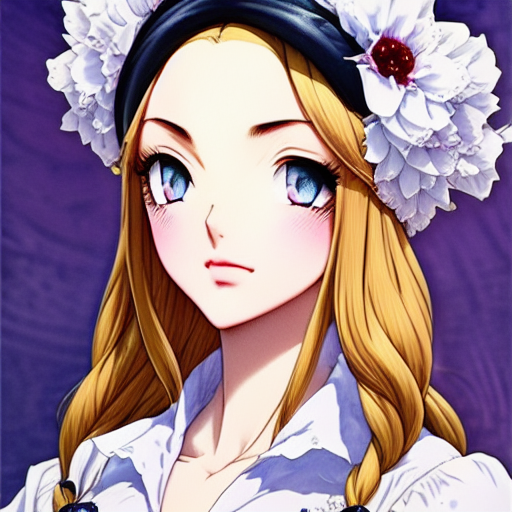

In [73]:
# Option#1: Test the TI model
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
import random
from IPython.display import display, HTML

if pipeline is None:
    pipeline = StableDiffusionPipeline.from_pretrained(
        "stable-diffusion-v1-5/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
    ).to("cuda")

    pipeline.enable_xformers_memory_efficient_attention()
    pipeline.load_textual_inversion(os.path.normpath(os.path.join(output_dir, f"{token_name}.safetensors")))

scheduler_args = {}

if "variance_type" in pipeline.scheduler.config:
    variance_type = pipeline.scheduler.config.variance_type

    if variance_type in ["learned", "learned_range"]:
        variance_type = "fixed_small"

    scheduler_args["variance_type"] = variance_type

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config, **scheduler_args)

random_number = random.randint(-0x8000_0000_0000_0000, 0xffff_ffff_ffff_ffff)
generator = torch.Generator().manual_seed(random_number)
display(HTML(f"Seed: 【<span style='color: yellow;'>{random_number}</span>】"))

preview_prompt ="a illustration of wpg, wear purple suit and hat"
negative_prompt = ""
negative_prompt += "glitch, spike, disfigured, kitsch, ugly, oversaturated, grain, low-res, Deformed, blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, poorly drawn hands, missing limb, blurry, floating limbs, disconnected limbs, malformed hands, blur, out of focus, long neck, long body, disgusting, poorly drawn, childish, mutilated, mangled, old, surreal"

output = pipeline(
    preview_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    guidance_scale=7,
)

display(output.images[0])

In [ ]:
# 4. Download your model
# If you are using Colab, you can mount Google Drive and upload your model in .safetensors format
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Create a directory in Google Drive if it doesn't exist
    import os
    target_dir = "/content/drive/MyDrive/TextualInversion"
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created directory: {target_dir}")
    else:
        print(f"Directory already exists: {target_dir}")

    # Copy your file to Drive
    !cp /content/{output_dir}/{token_name}.safetensors {target_dir}/{token_name}.safetensors
    print(f"Your Textual Inversion model has been uploaded to your Google Drive folder {target_dir}")
except:
  pass